In [1]:
import os
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer
from sklearn.decomposition import PCA
from configs.base import Config
root_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

/home/kuhaku/mambaforge-pypy3/envs/3m-ser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval_pca(opt, checkpoint_path, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    train_ds, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)).state_dict())
    network.eval()
    network.to(device)

    # Get train features
    X = []
    y = []
    for every_train_list in tqdm(train_ds):
        input_ids, audio, label = every_train_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            feature = network(input_ids,audio)[1].detach().cpu().numpy()[0]
            feature_norm = feature / np.linalg.norm(feature)
            X.append(feature_norm)
            y.append(label.detach().cpu().numpy()[0])
    
    # SVM
     
    pca = PCA(n_components=3)
    X_transformed = pca.fit_transform(X)
    fig = plt.figure(figsize=(5, 5))
    # 3D plot
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=y)
    # 2D plot
    # ax.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
    # remove ticks
    # ax.xaxis.set(ticks=())
    # ax.yaxis.set(ticks=())
    # set step 0.5 for ticks
    ax.xaxis.set(ticks=np.arange(-1.25, 1.26, 0.5))
    ax.yaxis.set(ticks=np.arange(-1.25, 1.26, 0.5))
    ax.zaxis.set(ticks=np.arange(-1.25, 1.26, 0.5))



    # add legend
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="")
    legend1.get_texts()[0].set_text('Angry')
    legend1.get_texts()[1].set_text('Happy')
    legend1.get_texts()[2].set_text('Sad')
    legend1.get_texts()[3].set_text('Neutral')
    ax.add_artist(legend1)



    # remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    plt.savefig(f"{opt.name}_pca.png", dpi=300, bbox_inches='tight')
    plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 127.11it/s]


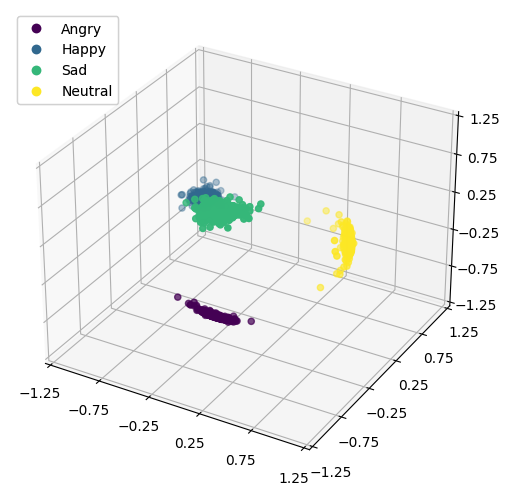

In [3]:
opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["1.0"]:
    opt.name = f"3M-SER_cel_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/best_acc/checkpoint_0.pt"
    eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 125.12it/s]


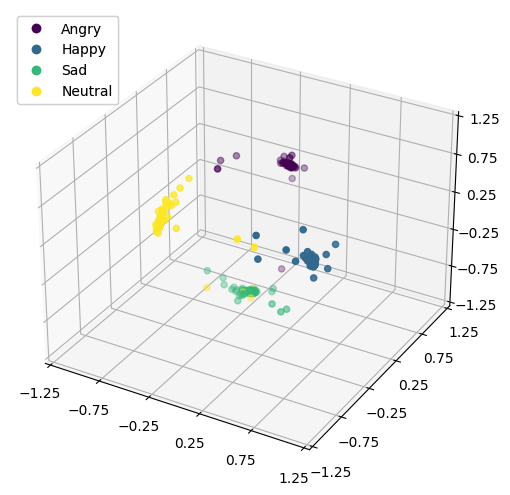

In [4]:
opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.name = "3M-SER_cel_cl_bert_vggish_ICTC"
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cel_cl_bert_vggish_ICTC/20230801-093922/weights/best_acc/checkpoint_0.pt"
eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 125.72it/s]


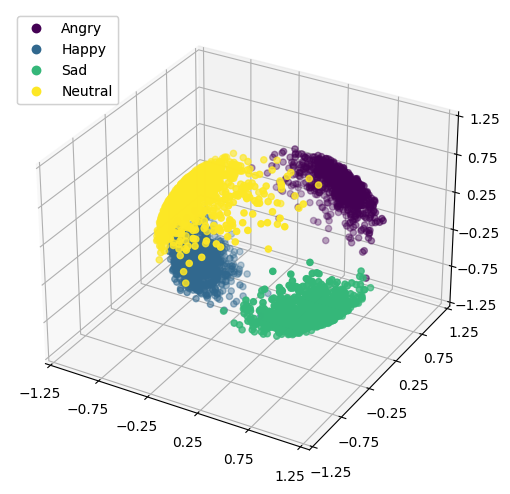

In [5]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.name = "3M-SER_cel_bert_vggish_ICTC"
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cel_bert_vggish_ICTC/20230805-140659/weights/best_acc/checkpoint_0.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:31<00:00, 119.61it/s]


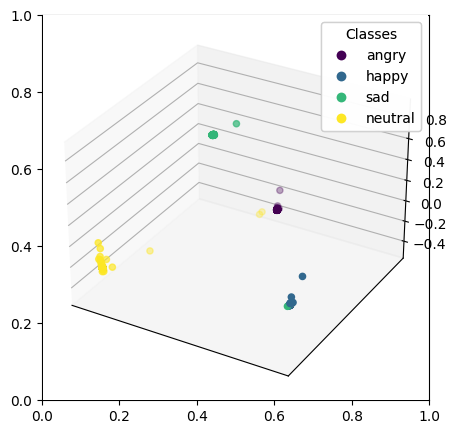

In [5]:


opt = Config()
opt.name = "3M-SER_cl_bert_vggish_ICTC"
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cl_bert_vggish_ICTC/20230729-161256/weights/checkpoint_932000.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval_pca(opt, checkpoint_path, tokenizer)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:31<00:00, 116.88it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore

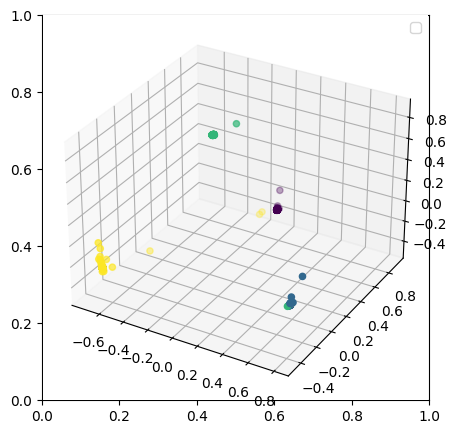

In [3]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.name = "3M-SER_cl_bert_vggish_ICTC"
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cl_bert_vggish_ICTC/20230729-161256/weights/checkpoint_932000.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:31<00:00, 116.85it/s]


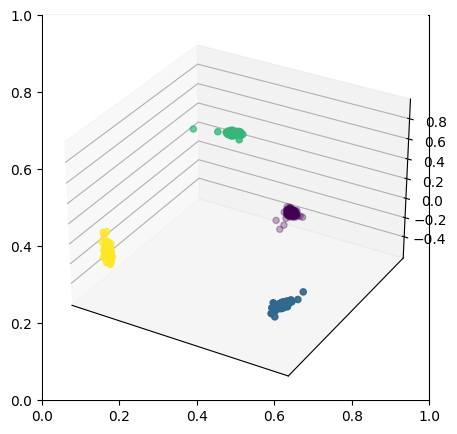

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:30<00:00, 122.52it/s]


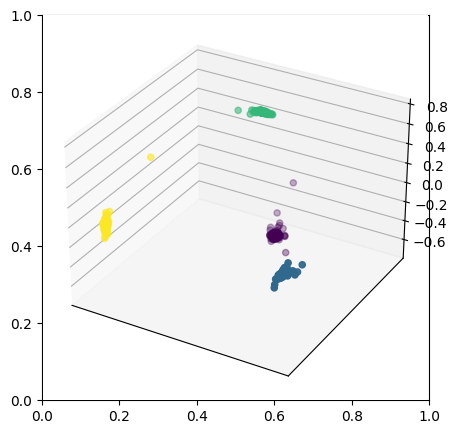

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:30<00:00, 123.61it/s]


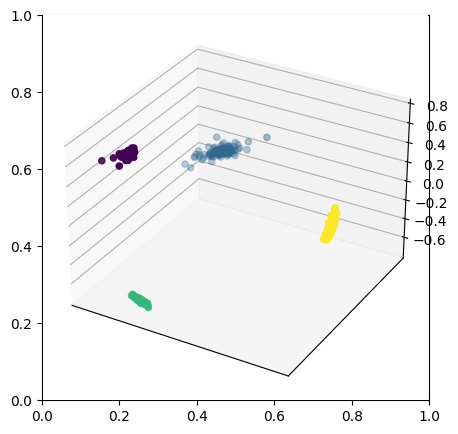

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 124.36it/s]


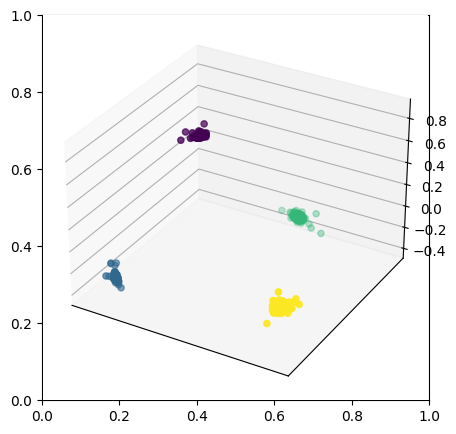

In [4]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"3M-SER_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_ccl_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/checkpoint_932000.pt"
    eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:30<00:00, 123.32it/s]


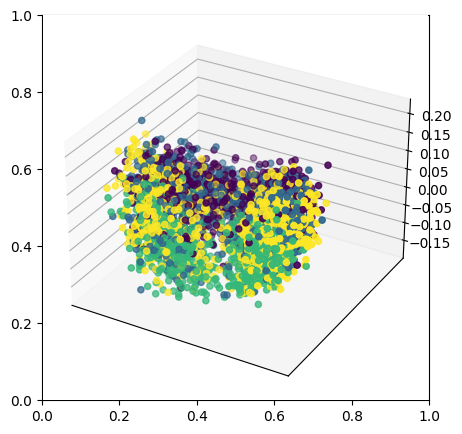

In [5]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.name = "SERVER_cl_bert_vggish_ICTC"
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_cl_bert_vggish_ICTC/20230729-161104/weights/checkpoint_932000.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 126.15it/s]


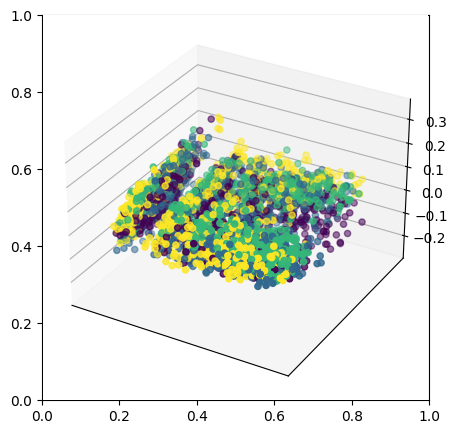

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:30<00:00, 122.62it/s]


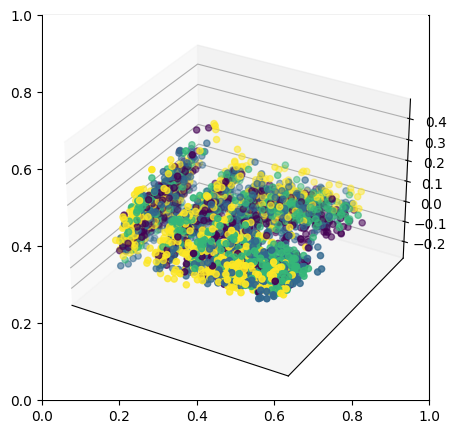

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 125.38it/s]


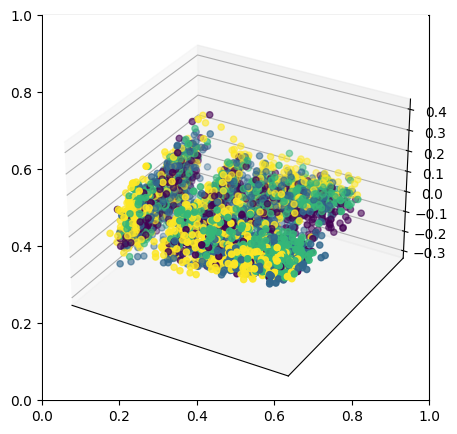

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 126.45it/s]


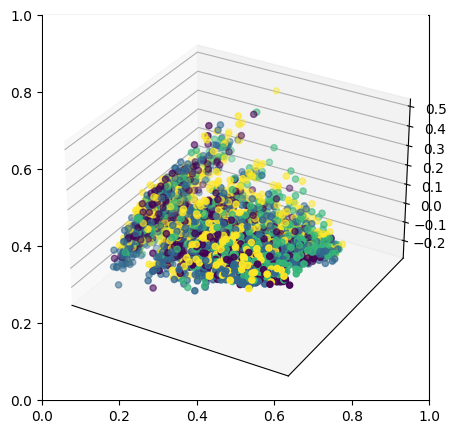

In [6]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"SERVER_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_ccl_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/checkpoint_932000.pt"
    eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 125.07it/s]


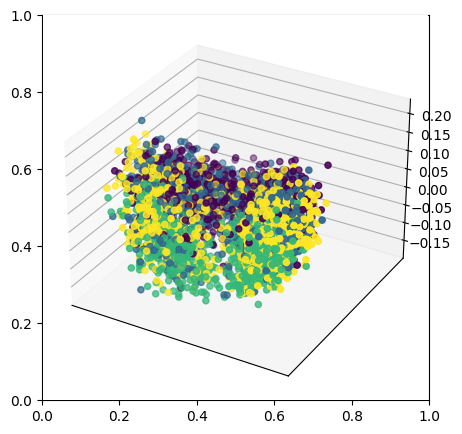

In [7]:
opt = Config()
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.name = "SERVER_cel_cl_bert_vggish_ICTC"
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_cel_cl_bert_vggish_ICTC/20230801-094024/weights/best_acc/checkpoint_0.pt"
eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 125.86it/s]


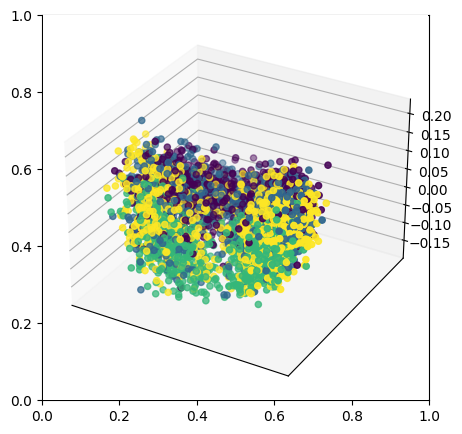

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 126.52it/s]


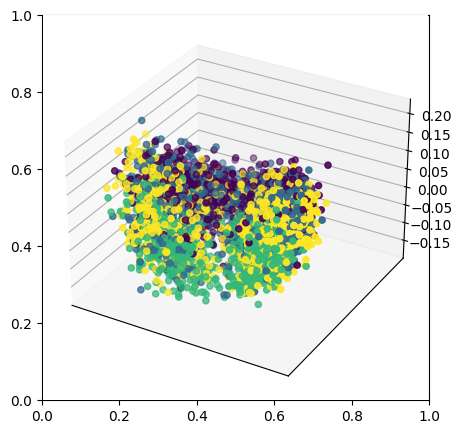

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 126.88it/s]


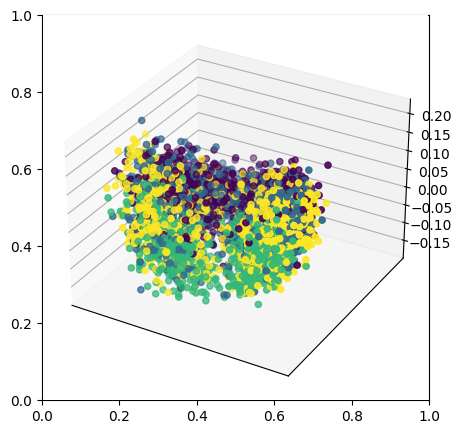

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 127.41it/s]


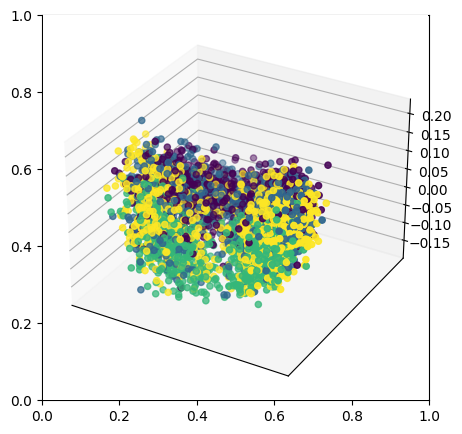

In [8]:
opt = Config()
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"SERVER_cel_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/best_acc/checkpoint_0.pt"
    eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 126.42it/s]


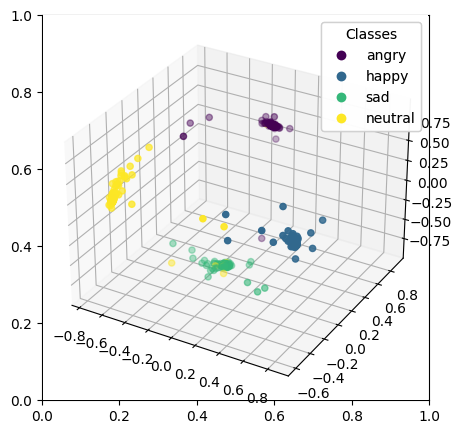

In [6]:
opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.name = "3M-SER_cel_cl_bert_vggish_ICTC"
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cel_cl_bert_vggish_ICTC/20230801-093922/weights/best_acc/checkpoint_0.pt"
eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:28<00:00, 128.75it/s]


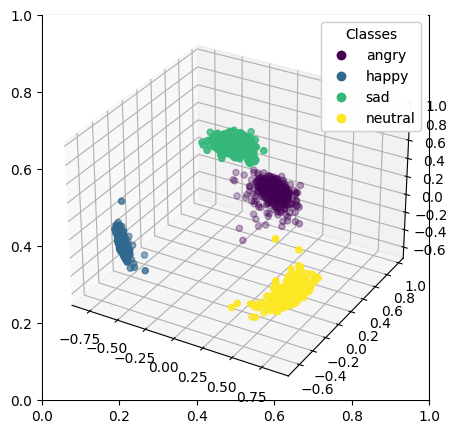

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:30<00:00, 122.64it/s]


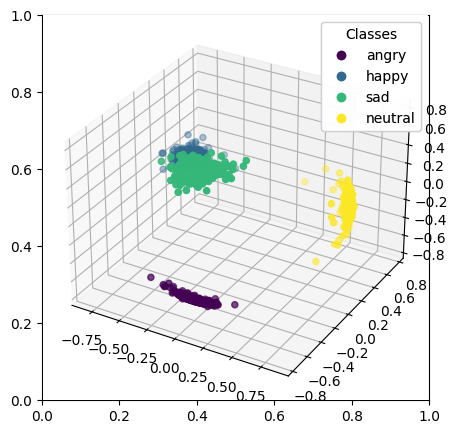

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 37%|███▋      | 1376/3728 [00:11<00:19, 123.68it/s]


KeyboardInterrupt: 

In [5]:
opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"MMSERA_cel_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/best_acc/checkpoint_0.pt"
    eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:33<00:00, 111.50it/s]


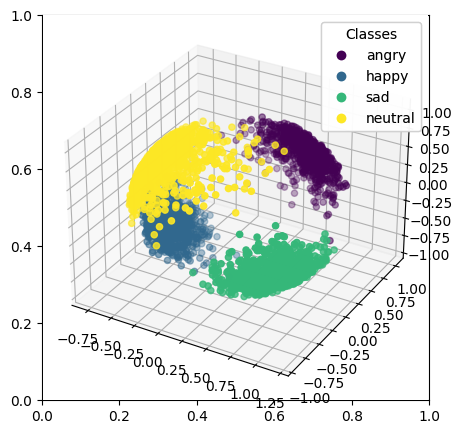

In [4]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.name = "3M-SER_cel_bert_vggish_ICTC"
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cel_bert_vggish_ICTC/20230805-140659/weights/best_acc/checkpoint_0.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval_pca(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3728/3728 [00:29<00:00, 126.08it/s]


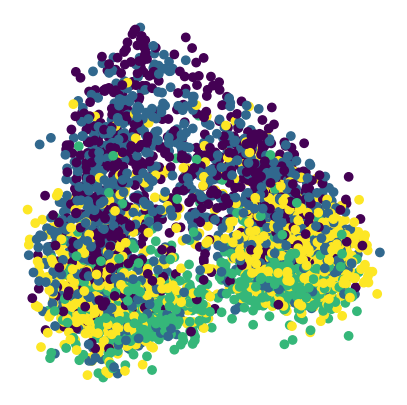

In [9]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.name = "SERVER_cel_bert_vggish_ICTC"
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_cel_bert_vggish_ICTC/20230805-140619/weights/best_acc/checkpoint_0.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval_pca(opt, checkpoint_path, tokenizer)